<a href="https://colab.research.google.com/github/COGS118A/Group004-Sp22/blob/main/Final_Project_group_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COGS 118A- Final Project

# Names

- Daniel Milton
- Isabella Gonzalez
- Dhruva Kolikineni
- Harini Adivikolanu
- Brandon Rocchio

# Abstract 
Classification involves predicting discrete class labels for unlabeled data. given information on the data. The data we are working with is information from individuals' shopping trips at Walmart. The data is broken down into 7 observations, one of which is the trip type which tells us what type of shopping trip this customer was on, visit number which organizes the data into individual shopping trips, weekday that the trip was done on, UPC number of the item purchased, department of purchase and the fineline number which is a number that Walmart made helping us specify the items purchased. Given certain data such as what weekday it is, what department it was in, and what the UPC was, our goal is to be able to predict what type of shopping trip someone was on based off of a couple pieces of data.



# Background

Although supervised classification methods have been studied greatly throughout the years, research specific to this problem, on classifying a grocery trip based on the items bought remains low. There are multiple classification algorithms we can attempt in order to classify the 38 different types of shopping trips there are. K-nearest neighbors, decision trees, random forest classifiers, neural networks and logistic regression are commonly used in order to solve classification problems. Due to the low amount of research done in this specific problem area, this background section will be a small literature review of potential classification algorithms to use for our problem.

Firstly, K Nearest Neighbors works based on the idea that for a target variable, the k number of patterns nearest to that target variable can provide useful information in order to properly classify the target variable. KNN assigns the target variable the classification of the majority of the nearest neighbors<a name="first"></a>[<sup>[1]</sup>](#firstnote). The downfalls of KNN are that there is no right 'K' to choose and it can be computationally inefficient. Second, Decision Trees are another classification method we want to attempt, these are popular due to their good accuracy scores and their computational efficiency<a name="second"></a>[<sup>[2]</sup>](#secondnote). The random forest classifier works by using multiple tree classifiers where each classifier is generated by using a random vector and each tree vottes for the most 'popular' class to classify an input vector<a name="third"></a>[<sup>[3]</sup>](#thirdnote). This paper uses random forests to classify remote sensing which they concluded was just as accurate as using a support vector machine.

Neural Networks and logistic regression are other potential algorithms we would like to try to classif our data with, there was no literature on any similar classification task to our project but a paper revealed that these two algorithms share common roots in statistical pattern recognition and that neural networks can be seen as a type of generalization from logistic regression<a name="fourth"></a>[<sup>[4]</sup>](#fourthnote). Lastly, upon multiple attempts to find related work, Cui et al attempted this trip type classification using deep embedding logistic regression which incorporates logistic regression into a deep and narrow neural network<a name="fifth"></a>[<sup>[5]</sup>](#fifthnote). We are hoping as we implement some of these algorithms to produce results and a discussion that can help future research for stores like Walmart to improve customers' shopping experiences or help understand/solve problems similar to this.

# Problem Statement

Walmart currently employs a proprietary method to catogorize shopping trips into 38 distinct types. We have set out to create a clustering/catagorization model that, given a limited set of customer behavior features, predicts the shopping trip types.

As an example for what these trip types may be: a customer may make a small daily dinner trip, a weekly large grocery trip, a trip to buy gifts for an upcoming holiday, or a seasonal trip to buy clothes.

#Setup

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import io
import tensorflow as tp
from tensorflow import keras

# Data


## Data Preprocessing:

In [24]:
## Load in train dataset
train = pd.read_csv((r'/content/train.csv'))

## Drop Upc column
#train.drop(columns=['Upc'], inplace = True)


## Find all rows with null values
null_vals = train[train.isna().any(axis=1)]

## I found from the above code that there is 4129 rows
## with null values. From this I found that Department Descriptions of
## PHARMACY RX always has a null FinelineNumber


## A check of all unique values in these columns to make sure if any
## further cleaning of the strings is needed
department_unique = train['DepartmentDescription'].unique()
weekday_unique = train['Weekday'].unique()
scancount_unique = train['ScanCount'].unique()

## Function to change the week days to quantitative variables, which allows us
## to do analysis on the Weekday column
def weekday_int_converter(x):
  if x=='Monday':
    return 0
  elif x=='Tuesday':
    return 1
  elif x=='Wednesday':
    return 2
  elif x=='Thursday':
    return 3
  elif x=='Friday':
    return 4
  elif x=='Saturday':
    return 5
  elif x=='Sunday':
    return 6 


train['Weekday'] = train['Weekday'].apply(weekday_int_converter)

## Filtered the train csv of all null values in the Department 
## Description column
train = train[train['DepartmentDescription'].notna()]


## We found there to be 60367 duplicate rows.
duplicates = train[train.duplicated()]

## We decided not to drop the duplicates as they may provide valuable data.
#train_duplicates_dropped = train.drop_duplicates()


## Add a column indicated if the trip includes return
train['Return'] = train['ScanCount']
train
def convert(x):
    if x >= 0:
        return 0
    else:
        return 1
train['Return'] = train['ScanCount'].apply(convert)

#Dropping NA values
train = train.dropna()

## Test any variable to see results
train.shape
print(train.head())
train.shape


   TripType  VisitNumber  Weekday           Upc  ScanCount  \
0       999            5        4  6.811315e+10         -1   
1        30            7        4  6.053882e+10          1   
2        30            7        4  7.410811e+09          1   
3        26            8        4  2.238404e+09          2   
4        26            8        4  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  Return  
0     FINANCIAL SERVICES          1000.0       1  
1                  SHOES          8931.0       0  
2          PERSONAL CARE          4504.0       0  
3  PAINT AND ACCESSORIES          3565.0       0  
4  PAINT AND ACCESSORIES          1017.0       0  


(642925, 8)

In order to clean our data, we imported the training data set, dropped the UPC column since we determined it was not a significant variable, changed weekdays into numerical categories, dropped all NA values as well as duplicate rows. 

## EDA

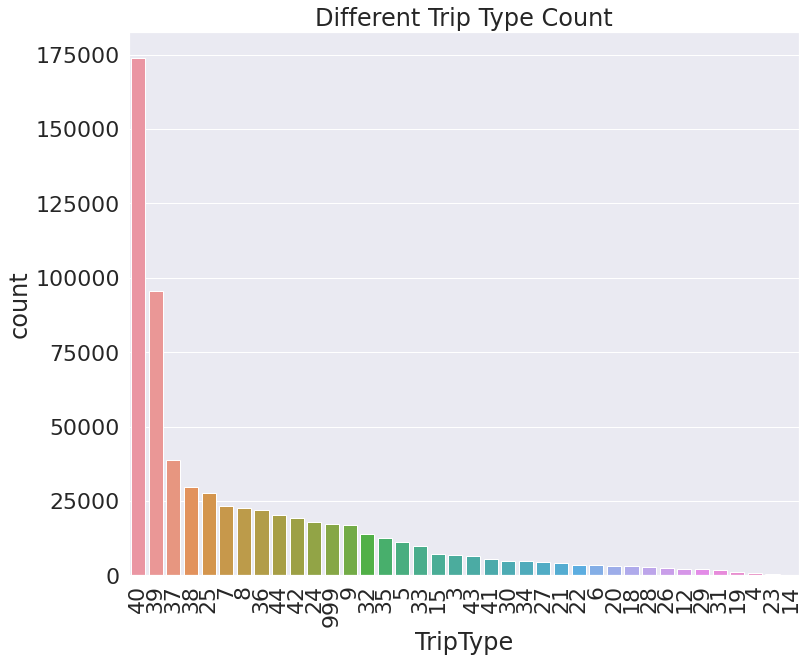

In [25]:
#Plotting Trip Type Frequency
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'TripType', data = train, order = train['TripType'].value_counts().index).set(title='Different Trip Type Count')
plt.xticks(rotation=90)
sns.set(font_scale=2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 <a list of 68 Text major ticklabel objects>)

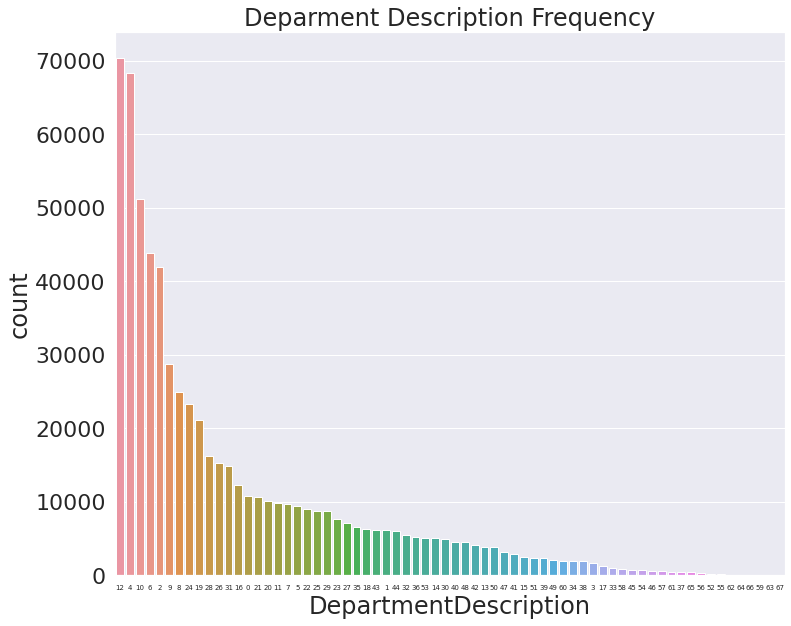

In [26]:
#Plotting Department Description Frequency
## Creating a dictionary to convert department descriptions to ints
department_list=list(train['DepartmentDescription'].unique())
department_enumerate=list(enumerate(department_list))
department_dict={v:k for k,v in department_enumerate}
train.replace({'DepartmentDescription': department_dict},inplace=True)

## Plotting
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'DepartmentDescription', data = train, order = train['DepartmentDescription'].value_counts().index).set(title='Deparment Description Frequency')
plt.xticks(fontsize=7)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

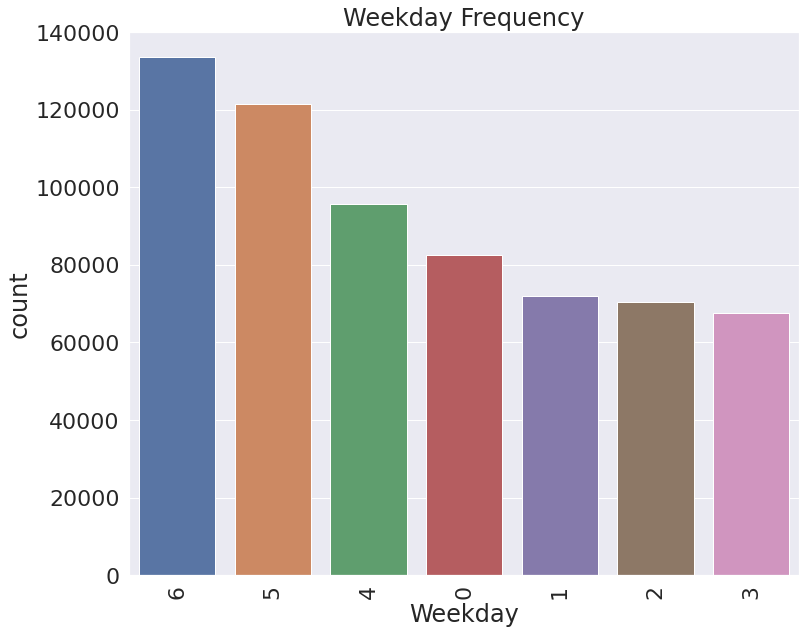

In [27]:
#Plotting Weekday Frequency
plt.figure(figsize = (12, 10))
sns.set_style('darkgrid')
sns.countplot(x = 'Weekday', data = train, order = train['Weekday'].value_counts().index).set(title='Weekday Frequency')
plt.xticks(rotation=90)

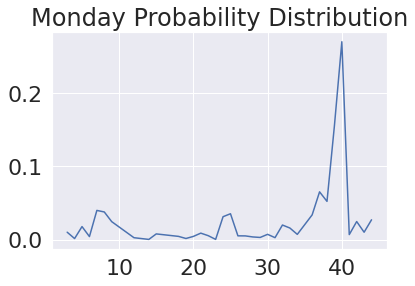

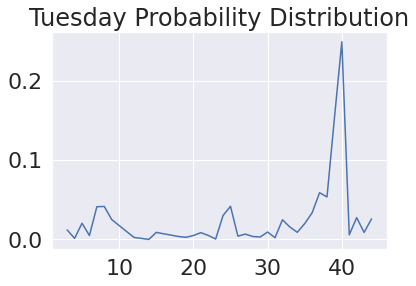

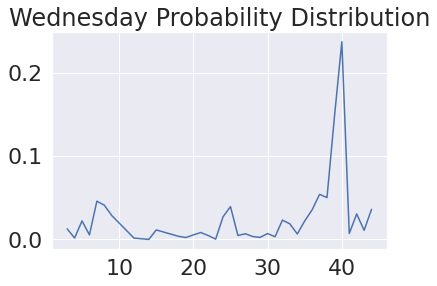

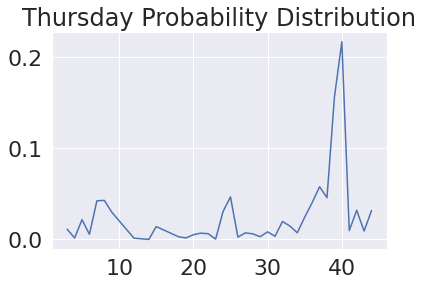

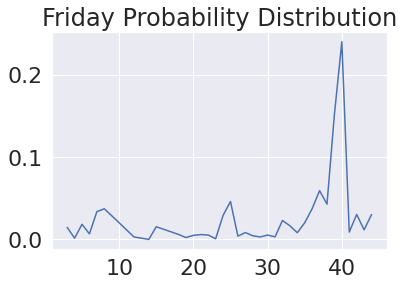

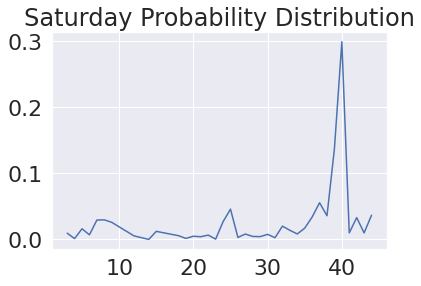

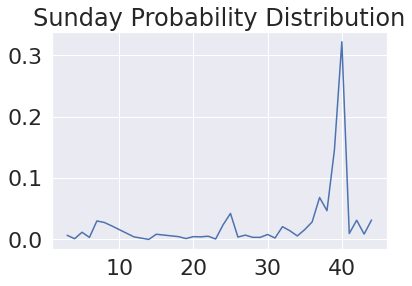

In [28]:
#Creating a pivot table to do bivariate analysis between TripType and Weekday
Weekday_TripType = (
   train
    .pivot_table(index='TripType', columns='Weekday', values=None, aggfunc='size').fillna(0)
)

#Calculating all the probabilities of getting a certain trip type, depending on the day of the week
for i in Weekday_TripType:
    Weekday_TripType[i] = Weekday_TripType[i] / Weekday_TripType[i].sum()
    
#Here I removed trip type 999 because it skewed our graph
Weekday_TripType = Weekday_TripType[:-1]

#Useful to decide how much weight to give weekdays in our model
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday',}
for i in Weekday_TripType:
    plt.figure()
    plt.plot(Weekday_TripType.index, Weekday_TripType[i])
    plt.title(weekdays[i] + ' Probability Distribution')

##Feature Engineering

In [29]:
## Feature Engineering




## Create a new df to append a groupby series of the sum of items bought in each trip
items_bought_each_trip = pd.DataFrame()



## Groupby function asssigned to new col
items_bought_each_trip['item_sum'] = train.groupby(['VisitNumber'])['ScanCount'].sum()


## This merge creates a df that makes only one row for each trip containing its sum of items
merged = items_bought_each_trip.reset_index().merge(train[['TripType', 'VisitNumber', 'Weekday']].drop_duplicates(), on='VisitNumber', how = 'left')



## Another dataframe to OHE departments
new_df = train.groupby(['VisitNumber', 'DepartmentDescription'])['ScanCount'].sum().reset_index()

## OHE
temp = pd.get_dummies(new_df, columns=['DepartmentDescription',])

## THis bit of code I iterated throught the department desciption columns and made an
## aggregate function to make only one row per trip with each deparment description it 
## had showing as one
new_dict = {}
for i in temp:
    new_dict[i] = 'sum'
final = temp.groupby(temp['VisitNumber']).aggregate(new_dict)
final = final.iloc[: , 1:].reset_index()



## Merging the final df and merged df
temp = merged.merge(final, on='VisitNumber')


Turning weekday into cyclical variables with sine and cosine

In [30]:
day_of_week = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
day = temp['Weekday'].map(day_of_week)
temp['sin_day'] = np.sin(2*np.pi*day/7)
temp['cos_day'] = np.cos(2*np.pi*day/7)
temp = temp.drop(['Weekday'], axis=1)
temp

,VisitNumber,item_sum,TripType,ScanCount,DepartmentDescription_0,DepartmentDescription_1,DepartmentDescription_2,DepartmentDescription_3,DepartmentDescription_4,DepartmentDescription_5,...,DepartmentDescription_60,DepartmentDescription_61,DepartmentDescription_62,DepartmentDescription_63,DepartmentDescription_64,DepartmentDescription_65,DepartmentDescription_66,DepartmentDescription_67,sin_day,cos_day
0,5,-1,999,-1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
1,7,2,30,2,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
2,8,27,26,27,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
3,9,3,8,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
4,10,3,8,3,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94242,191343,9,25,9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.781831,0.623490
94243,191344,5,22,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.781831,0.623490
94244,191345,17,39,17,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-0.781831,0.623490
94245,191346,17,39,17,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,-0.781831,0.623490


In [31]:
from sklearn.preprocessing import StandardScaler

#Standardizing remaining Numerical Variables
sc = StandardScaler()
temp[['VisitNumber', 'item_sum', 'ScanCount']] = sc.fit_transform(temp[['VisitNumber', 'item_sum', 'ScanCount']])

## Final Test Set 
We will reserve 10% of our data for final validation. This will serve as our overall task performance benchmark.

In [58]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(temp, test_size = 0.1)
final_y_test = test_set['TripType']
final_X_test = test_set.drop(columns=["TripType"])
final_X_train = train_set.drop(columns=["TripType"])
final_y_train = train_set['TripType']

##Partitioning Train/Test Sets:
Since we are working very large dataset (500k+ datapoints), we found we had enough data to train models using a simple train-test partition with 70% of the datapoints in the training set and 30% in the validation set. 

In [33]:
from sklearn.model_selection import train_test_split
#X = temp
y = train_set['TripType']
X = train_set.drop(columns=['TripType'])
#y = temp['TripType']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, train_size = .70, shuffle=True)
print (y_test.unique().shape)
print(X_train.shape)


(38,)
(59375, 73)


# Proposed Solution

Our proposed solution is to use train and fit a model to the training data, evaluate its performance on the testing data, and then use cross validation to verify the accuracy of our results.

Given the nature of our problem, non-binary classification of trip type into 38 distinct categories, we have isolated some models we believe would be best suited for the task:

- Random Forest 
- Neural Networks

####Note On Model Selection:
The nature of our dataset naturally lends itself to certain models and leave other ones unviable. Because of the number of features we have and the large dataset, K-NN Classifiers would suffer. Logistic regression is another such classifer that we can rule out due to the non binary catagorization of our dataset. 

we also are constrained in our compute time and resource, this means that certain classifiers that have more complex training times must be evaluated more harshly.


# Evaluation Metrics

Given the context of our data and intended solution, we need a multiclass evaluation metric. Thus, we've chosen to evaluate the performance of our benchmark model and solution models by calculating the F1-score. The F1-score combines two metrics, precision and recall, using their harmonic mean to give one single number. Therefore, the F1-score would allow us to take both the number of false positives and false negatives of trip type classification into account. Further, the F1-score is a useful evaluation metric to compare against the accuracy scores of our proposed models, considering that we have an uneven class distribution. For this reason, we chose to calculate the F1-score with a weighted average to take into account the proportion of each trip type label in our dataset.



#Results


In search of the optimal model, we will instantiate each of our hypothesized algorithms and perform a hyperparameter sweep on each to select the best parameters. This allows each classifier to put it's best foot forward during their eventual model comparison.



## Subsection 1: Random Forests

Our base random forest classifier model uses a maximum depth of 30 nodes and gives an average accuracy score of 0.63, precision score of 0.61, recall score of 0.63, and f1-score of 0.60. From here, we chose to hyperparameter tune the n_estimators paramter to evaluate how many trees we should consider in our model.

###Base Model 

Training and testing Base Model:

In [34]:
from sklearn.ensemble import RandomForestClassifier
#Initalizing and training a random forest classifier
rfc = RandomForestClassifier(max_depth=30) #insert best parameters here
rfc.fit(X_train, y_train)

# Predicting the Test set results
pred = rfc.predict(X_test)
pred

array([39, 25,  3, ...,  5,  5,  9])

###Results

Base model results:

In [35]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.79      0.94      0.86       986
           4       0.00      0.00      0.00        94
           5       0.60      0.70      0.65       904
           6       0.73      0.60      0.66       349
           7       0.66      0.62      0.63      1569
           8       0.74      0.87      0.80      3286
           9       0.66      0.78      0.72      2557
          12       0.00      0.00      0.00        72
          14       0.00      0.00      0.00         1
          15       0.51      0.33      0.40       261
          18       0.50      0.32      0.39       151
          19       0.33      0.10      0.15       104
          20       0.50      0.49      0.49       175
          21       0.61      0.54      0.57       171
          22       0.35      0.10      0.16       251
          23       1.00      0.03      0.05        38
          24       0.55      0.47      0.50       705
          25       0.55    

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:", precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

Overall Accuracy: 0.6275788894565175
Overall F1_score: 0.601175320474753
Overall Precision: 0.607511129627696
Overall Recall: 0.6275788894565175


In [37]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)

print(confusion_matrix)

[[ 925    0    4 ...    0    0   12]
 [   0    0   76 ...    0    0    0]
 [   1    9  634 ...    0    0    0]
 ...
 [   0    1    8 ...    1    1    0]
 [   0    0    3 ...    0    3    0]
 [ 192    0   19 ...    0    0 1612]]


###Hyperparameter Tuning

In [38]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
rfc = RandomForestClassifier(max_depth = 30)
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [42]:
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [100,200,50]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None,30,50]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               }


GSCV = GridSearchCV(rfc,random_grid,scoring="f1_weighted",cv = 2, verbose =3)
GSCV.fit(X_train,y_train)
print(GSCV.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END max_depth=None, max_features=auto, n_estimators=100;, score=0.583 total time=  10.4s
[CV 2/2] END max_depth=None, max_features=auto, n_estimators=100;, score=0.583 total time=  10.9s
[CV 1/2] END max_depth=None, max_features=auto, n_estimators=200;, score=0.583 total time=  20.3s
[CV 2/2] END max_depth=None, max_features=auto, n_estimators=200;, score=0.584 total time=  19.9s
[CV 1/2] END max_depth=None, max_features=auto, n_estimators=50;, score=0.579 total time=   5.4s
[CV 2/2] END max_depth=None, max_features=auto, n_estimators=50;, score=0.583 total time=   5.4s
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=100;, score=0.582 total time=  10.3s
[CV 2/2] END max_depth=None, max_features=sqrt, n_estimators=100;, score=0.584 total time=  10.3s
[CV 1/2] END max_depth=None, max_features=sqrt, n_estimators=200;, score=0.583 total time=  19.5s
[CV 2/2] END max_depth=None, max_features=sqrt, n_estimator

Training and testing best Hyperparameter model:

In [43]:
from sklearn.ensemble import RandomForestClassifier
#using random forest to classify data based on tuned hyperparams
best_rfc = RandomForestClassifier(n_estimators = 200, max_features = 'auto', max_depth = 30)
best_rfc.fit(X_train, y_train)

# Predicting the Test set results
pred = best_rfc.predict(X_test)
pred

array([39, 25,  3, ..., 39,  5,  9])

Best Hyperparameter model results:

In [44]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.79      0.93      0.86       986
           4       0.00      0.00      0.00        94
           5       0.60      0.70      0.65       904
           6       0.74      0.61      0.67       349
           7       0.66      0.61      0.64      1569
           8       0.74      0.87      0.80      3286
           9       0.65      0.79      0.71      2557
          12       0.00      0.00      0.00        72
          14       0.00      0.00      0.00         1
          15       0.51      0.31      0.39       261
          18       0.51      0.25      0.33       151
          19       0.35      0.08      0.13       104
          20       0.53      0.51      0.52       175
          21       0.60      0.55      0.57       171
          22       0.34      0.09      0.14       251
          23       0.00      0.00      0.00        38
          24       0.55      0.46      0.51       705
          25       0.54    

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:", precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

Overall Accuracy: 0.6288364050772193
Overall F1_score: 0.6014654538131688
Overall Precision: 0.6089963245103776
Overall Recall: 0.6288364050772193


In [46]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)

print(confusion_matrix)

[[ 917    0    2 ...    0    0   21]
 [   0    0   75 ...    0    0    0]
 [   2    6  635 ...    2    0    0]
 ...
 [   0    1    7 ...    1    1    0]
 [   0    0    3 ...    0    4    0]
 [ 190    0   19 ...    0    0 1614]]


## Subsection 2: Neural Networks

###Base Model

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
NN = MLPClassifier(hidden_layer_sizes=(), solver='adam', random_state=1, activation ="relu", learning_rate="constant", alpha=0.0001)

NN.fit(X_train,y_train)
pred = NN.predict(X_test)
pred 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


array([39, 25,  3, ...,  5,  5, 22])

###Results

In [48]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.79      0.91      0.84       986
           4       0.00      0.00      0.00        94
           5       0.57      0.79      0.66       904
           6       0.58      0.64      0.61       349
           7       0.64      0.65      0.65      1569
           8       0.69      0.85      0.76      3286
           9       0.63      0.75      0.69      2557
          12       0.40      0.17      0.24        72
          14       0.00      0.00      0.00         1
          15       0.49      0.38      0.43       261
          18       0.45      0.51      0.48       151
          19       0.29      0.19      0.23       104
          20       0.47      0.55      0.51       175
          21       0.58      0.51      0.54       171
          22       0.36      0.33      0.34       251
          23       0.41      0.34      0.37        38
          24       0.57      0.59      0.58       705
          25       0.60    

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:",precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

Overall Accuracy: 0.6183440091169883
Overall F1_score: 0.6061891450301785
Overall Precision: 0.6100445505125927
Overall Recall: 0.6183440091169883


In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[ 897    0    2 ...    0    0   26]
 [   0    0   85 ...    0    0    0]
 [   1    0  718 ...    0    1    0]
 ...
 [   0    0    5 ...    8    4    0]
 [   0    0    0 ...    5   70    0]
 [ 196    0   21 ...    0    1 1373]]


###Hyperparameter Tuning 

In [51]:
from sklearn.model_selection import GridSearchCV

NN_params = {
    'hidden_layer_sizes': [(), (100,),(100,60)],
    #'activation': ['tanh', 'relu'],
    #'solver': ['sgd', 'adam'], We found adam to be the most efficient in the majority of cases
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

grid = GridSearchCV(NN, NN_params, scoring='f1_weighted', cv=2, verbose=2)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=constant; total time=  43.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=constant; total time=  43.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=adaptive; total time=  44.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(), learning_rate=adaptive; total time=  43.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 1.3min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 1.4min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=  57.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 60), learning_rate=constant; total time= 1.1min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 60), learning_rate=constant; total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 60), learning_rate=adaptive; total time= 2.0min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.0001, hidden_layer_sizes=(100, 60), learning_rate=adaptive; total time= 1.8min


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV] END alpha=0.05, hidden_layer_sizes=(), learning_rate=constant; total time=  43.7s
[CV] END alpha=0.05, hidden_layer_sizes=(), learning_rate=constant; total time=  40.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(), learning_rate=adaptive; total time=  11.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(), learning_rate=adaptive; total time=  11.9s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100,), learning_rate=constant; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100,), learning_rate=constant; total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100,), learning_rate=adaptive; total time=   6.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100, 60), learning_rate=constant; total time=  11.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100, 60), learning_rate=constant; total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100, 60), learning_rate=adaptive; total time=   9.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END alpha=0.05, hidden_layer_sizes=(100, 60), learning_rate=adaptive; total time=   9.4s
{'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


####Best hyperparameter model

In [52]:
# Creating a model based on the best combination of hyperparams found in Gridsearch
best_NN = MLPClassifier(hidden_layer_sizes=(100), solver='adam', random_state=1, activation ="relu", learning_rate="constant", alpha=0.0001)

best_NN.fit(X_train,y_train)
pred = best_NN.predict(X_test)
pred 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


array([43, 25,  3, ...,  5,  5, 22])

In [54]:
from sklearn. metrics import classification_report

print(classification_report(y_test, pred, zero_division=0))

              precision    recall  f1-score   support

           3       0.79      0.93      0.86       986
           4       0.00      0.00      0.00        94
           5       0.61      0.75      0.67       904
           6       0.67      0.72      0.70       349
           7       0.66      0.69      0.67      1569
           8       0.80      0.84      0.82      3286
           9       0.71      0.75      0.73      2557
          12       0.47      0.21      0.29        72
          14       0.00      0.00      0.00         1
          15       0.53      0.39      0.45       261
          18       0.43      0.44      0.43       151
          19       0.28      0.18      0.22       104
          20       0.57      0.46      0.51       175
          21       0.56      0.62      0.59       171
          22       0.37      0.48      0.42       251
          23       0.36      0.55      0.43        38
          24       0.54      0.60      0.57       705
          25       0.59    

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Overall Accuracy:",accuracy_score(y_test, pred))
print("Overall F1_score:",f1_score(y_test, pred, average = "weighted", zero_division =0))
print("Overall Precision:",precision_score(y_test, pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(y_test, pred, average='weighted', zero_division=0))

Overall Accuracy: 0.6424332927260581
Overall F1_score: 0.6347243429540622
Overall Precision: 0.6362285366564226
Overall Recall: 0.6424332927260581


##Subsection 3: Model Comparison

To compare the efficacy of our models in predicting which trip type class each of our data points belonged to, we used the 10% reserve of our data—our final test set—to validate our results.

### Comparing Best Models on Final Train Test Set

In [60]:
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

# Import required libraries for machine learning classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


  
best_rfc.fit(final_X_train,final_y_train)
best_NN.fit(final_X_train,final_y_train)

    


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=100, random_state=1)

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
rfc_pred = best_rfc.predict(final_X_test)
#Overall Totals for RFC
print('Overall Totals for the Random Forest Classifier:')
print("Overall Accuracy:",accuracy_score(final_y_test, rfc_pred))
print("Overall F1_score:",f1_score(final_y_test, rfc_pred, average = "weighted", zero_division =0))
print("Overall Precision:", precision_score(final_y_test, rfc_pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(final_y_test, rfc_pred, average='weighted', zero_division=0))

print("_______________________________________")
NN_pred = best_NN.predict(final_X_test)
#Overall Totals for NN
print('Overall Totals for the Neural Network Classifier:')
print("Overall Accuracy:",accuracy_score(final_y_test, NN_pred))
print("Overall F1_score:",f1_score(final_y_test, NN_pred, average = "weighted", zero_division =0))
print("Overall Precision:", precision_score(final_y_test, NN_pred, average='weighted', zero_division=0))
print("Overall Recall:",recall_score(final_y_test, NN_pred, average='weighted', zero_division=0))
  

Overall Totals for the Random Forest Classifier:
Overall Accuracy: 0.6312997347480106
Overall F1_score: 0.6059236614444571
Overall Precision: 0.6209871766654727
Overall Recall: 0.6312997347480106
_______________________________________
Overall Totals for the Neural Network Classifier:
Overall Accuracy: 0.6484880636604774
Overall F1_score: 0.6368946745601064
Overall Precision: 0.6418914160003153
Overall Recall: 0.6484880636604774


# Discussion

###Subsection 1: Random Forests

The results of our random forest classifier gave an average accuracy of 0.63, precision score of 0.61, recall score of 0.63, and f1-score of 0.60. From these results, we can interpret that this classifier's predictive positive value and sensitivity to our trip type classes was relatively equal, and that our f1-score did not exceedingly compromise one measure over another. We can attribute our accuracy and f1 scores scores to the fact that random forests are able to classify categorical variables without feature scaling and while handling outliers robustly. Thus, our model was able to overcome the class imbalance of our dataset relatively well, although this came with the compromise of training a model with greater tree depth and nodes.

###Subsection 2: Neural Networks with SKLearn

To test another multi-classification modeling technique on our data, we turned to neural networks. First, we built a base neural network model using SKLearn. We achieved an average score of 0.62, precision score of 0.61, recall score of 0.64, and the f1-score to 0.61. Interpreting these results, we found that this model similarly accounted for both precision and recall relatively equally. Moreover, we found that the benefit to using neural networks was that we were able to generalize our model to our data, despite having a dataset with some insufficient/incomplete data points. 


###Subsection 3: Model Comparison
Both of the models we chose to use are very powerful and, given the nature of the problem, do an exceptional job finding signal in the relative noise of human shopping behavior at Walmart. We are able to get >60% accuracy rates with both models. In the final analysis, we were able to get slighly better classification scores using the Neural Network model. This result is encouraging. Given the relative elementary nature of the models we trained, being able to such scores illuminates the potential for these models to solve complex problems. Given more training time and data input, neural networks can get shockingly good at these types of classification tasks. 

# Limitations

**Constrained Model Training:**
Given the compute resource contraint, we were only able to train all of our models with a class balanced random sample (75k samples) of the larger training dataset. This was done to allow for faster training times, which ultimately allowed for more granular hyperparameter tuning. We then trained/tested the best model on the entire dataset. Thus, the size of our sample and compute resource were significant limitations in this project.

**Knowledge of Neural Networks:**
bold textWe chose to explore modeling with neural networks as it was a common interest among our entire group. However, as we only have introductory knowledge of neural networks, we didn't have sufficient understanding to optimize our model to the best it could be. For example, although we invested effort into researching hidden layer architecture, we ultimately had to hand-design the number of layers/nodes in our model by making our best educated guess. We also spent time experimenting with packages outside the scope of our knowledge base such as Keras, but were unsucsessful in producing desirable results.

# Ethics & Privacy

Our data does not involve anyones data or identity so it would be difficult to find a breach of ethics or privacy. One ethical dilemma that might arise is the increasing amount of data available to big corporations and how they’re using this big data to fine tune their products to keep the average person consuming even more. It would be prudent to question whether it is completely ethical for corporations to treat everyone as a number to maximize their profits.




# Team Expectations 

Put things here that cement how you will interact/communicate as a team, how you will handle conflict and difficulty, how you will handle making decisions and setting goals/schedule, how much work you expect from each other, how you will handle deadlines, etc...

- Arrange bi-weekly meetings that works with everyones schedule
- Use a discord server to communicate with one another
- Make use of project managment software to track progress
- Be mindful of git -pull-push-overwrites such that no code is overwritten or needlessly repeated

# Project Timeline Proposal

UPDATE THE PROPOSAL TIMELINE ACCORDING TO WHAT HAS ACTUALLY HAPPENED AND HOW IT HAS EFFECTED YOUR FUTURE PLANS

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 4/24  |  3:30 PM |  Edit, finalize, and submit proposal; Search for datasets  | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part | 
| 5/16  |  9 PM |  Delegate tasks for first checkpoint and discuss wrangling, cleaning, and EDA plan | Import and wrangle data, do some EDA | 
| 5/19  | 9 PM  | Edit and finalize data cleaning and wrangling/EDA  | Review/discuss EDA, debug, and submit checkpoint   |
| 5/23  | 7 PM  | Finalize project/conclusion/discussion | Discuss conclusion   |
| 6/8  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="first"></a>1.[^](#firstnote): Oliver Kramer. K Nearest Neighbors. https://link.springer.com/chapter/10.1007/978-3-642-38652-7_2<br> 
<a name="second"></a>2.[^](#secondnote): Srivastava et al. (1999) Parallel Forumlations of Decision Tree Classfication Algorithms. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.41.7475&rep=rep1&type=pdf<br>
<a name="third"></a>3.[^](#thirdnote): M. Pal (2005).Random forest classifier for remote sensing classification. https://www.tandfonline.com/doi/pdf/10.1080/01431160412331269698?casa_token=e78vG4sBDLcAAAAA:p9nt0mSjEMuazyQsDjprmwIIFt9aNRk9EtF7eKRyNozF6FsAskuvXKrMxnnftOK0xFjlUm5MX9g.<br>
<a name="fourth"></a>4.[^](#fourthnote): Stephan Dreiseitl and Lucila Ohno_Machado. (2002). Logistic regression and artificial neural network classification models: a methodology review. https://www.sciencedirect.com/science/article/pii/S1532046403000340.<br>
<a name="fifth"></a>5.[^](#fifthnote): Cui et al. (2018). Deep Embedding Logistic Regression. https://ieeexplore.ieee.org/document/8588790

